In [8]:
# load contact localization dataset
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
import torch
from torchvision import transforms
from torchinfo import summary 
import argparse


class create_tensor_dataset_localization(Dataset):
    def __init__(self, path = './dataset/realData/contact_detection_train.csv', transform = transforms.Compose([transforms.ToTensor()]), num_classes =5,
                 num_features_dataset = 14, num_features_lstm = 2, data_seq = 28, desired_seq = 28, localization= False, collision =False, dof = 7):
        self.path = path
        self.transform = transform
        self.num_features_dataset = num_features_dataset
        self.num_features_lstm = num_features_lstm
        self.data_seq = data_seq
        self.desired_seq = desired_seq
        self.dof = dof
        self.num_classes = num_classes
        self.localization = localization
        self.collision = collision
        if collision and localization:
            print('collision and localization cannot be true at the same time!')
            exit()
            

        self.read_dataset()
        self.data_in_seq()
        
    def __len__(self):
        return len(self.data_target)


    def __getitem__(self, idx: int):

        data_sample = torch.tensor(self.data_input.iloc[idx].values)
        data_sample = torch.reshape(data_sample, (self.dof ,self.num_features_lstm*self.desired_seq))

        target = self.data_target.iloc[idx]

        return data_sample, target


    def read_dataset(self):
        
        # laod data from csv file
        if self.path[(len(self.path)-3): len(self.path)] == 'csv':
            data = pd.read_csv(self.path)
        elif self.path[(len(self.path)-3): len(self.path)] == 'pkl':
            data = pd.read_pickle(self.path)
        # specifying target and data
        data_input = data.iloc[:,1:data.shape[1]]
        data_target = data.iloc[:,0]

        if not self.localization:
            data_target.loc[data_target.iloc[:]!=0] = 1

        if self.localization or self.collision:
            #if 0 in data_target.unique():
            data_input = data_input.loc[data_target.iloc[:]!=0, :]
            data_target = data_target.loc[data_target.iloc[:]!=0]
            data_target = data_target-1


        self.data_input = data_input.reset_index(drop=True)
        self.data_target = data_target.reset_index(drop=True)
        

    def data_in_seq(self):

        dof = self.dof

        # resorting item position
        data = np.array( range(0, self.num_features_dataset * self.data_seq ))
        data = data.reshape(self.data_seq, self.num_features_dataset)

        joint_data_pos = []
        for j in range(dof):
                 
            column_index = np.array(range(self.num_features_lstm))*dof +j
            row_index= range(self.data_seq-self.desired_seq, self.data_seq)
            join_data_matrix = data[:, column_index]
            joint_data_pos.append(join_data_matrix.reshape((len(column_index)*len(row_index))))
        
        joint_data_pos = np.hstack(joint_data_pos)

        # resorting (28,28)---> (4,28)(4,28)(4,28)(4,28)(4,28)(4,28)(4,28)

        self.data_input.columns = range(self.num_features_dataset * self.data_seq)
        self.data_input = self.data_input.loc[:][joint_data_pos]

# load models

In [74]:
#load models
import os
import time
import torch
import numpy as np
import random
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from torchmetrics import ConfusionMatrix, Accuracy
import matplotlib.pyplot as plt
import torch.nn.functional as F

def get_output(data_loader, model, device):
    model.eval()
    labels_pred = []
    labels_true = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).long()
            output = model(X_batch) # Return the prediction for each joint step (batch_size, joint_seq)
            probabilities = F.softmax(output, dim=1) 
            
            #preds = (output > 0.8).int()  # Binarize output
            preds = probabilities.argmax(axis=1)
            labels_pred.append(preds.cpu().numpy())
            labels_true.append(y_batch.cpu().numpy())

    # Convert lists to arrays
    labels_pred = np.concatenate(labels_pred, axis=0)
    labels_true = np.concatenate(labels_true, axis=0)

    # Convert numpy arrays back to tensors
    labels_pred = torch.tensor(labels_pred, dtype=torch.int64)  # Ensure long tensor for labels
    labels_true = torch.tensor(labels_true, dtype=torch.int64)  # Ensure long tensor for labels

    return labels_pred, labels_true
    
class ZScoreNormalization(nn.Module):
    def __init__(self):
        super(ZScoreNormalization, self).__init__()

    def forward(self, x):
        # Assuming input x has shape (batch_size, DOF,joint_seq)
        batch_size, DOF,joint_seq  = x.shape

        # Create a placeholder for the normalized output
        normalized_x = torch.zeros_like(x)
        
        # Apply normalization for each DOF independently
        for dof in range(DOF):
            # Normalize along the joint_seq dimension for each DOF
            mean = torch.mean(x[:, dof, :], dim=1, keepdim=True)
            std = torch.std(x[:, dof,:], dim=1, keepdim=True)
            normalized_x[:, dof, :] = (x[:, dof, :] - mean) / (std + 1e-6)  # Add epsilon to avoid division by zero
        
        return normalized_x

class ZScoreNormalization(nn.Module):
    def __init__(self, time_seq):
        super(ZScoreNormalization, self).__init__()
        self.time_seq = time_seq

    def forward(self, x):
            # Assuming input x has shape (batch_size, DOF,joint_seq)
            batch_size, DOF,joint_seq  = x.shape

            # Create a placeholder for the normalized output
            reshaped_x = x.reshape((batch_size, DOF, joint_seq//self.time_seq, self.time_seq))
            normalized_x = torch.zeros_like(reshaped_x)
            
            # Apply normalization for each DOF independently
            for dof in range(DOF):
                # Normalize along the joint_seq dimension for each DOF
                for i in range(joint_seq//self.time_seq):
                    segment = reshaped_x[:, dof, i,:]
                    mean = torch.mean(segment, dim=1, keepdim=True)
                    std = torch.std(segment, dim=1, keepdim=True)
                    normalized_x[:, dof, i,:] = segment/ (std + 1e-6)  # Add epsilon to avoid division by zero
            '''print(x)
            print(reshaped_x)
            print(normalized_x)'''
            normalized_x = normalized_x.reshape( (batch_size, DOF,joint_seq))
            #print(normalized_x)
            return normalized_x

class lstmBlock(nn.Module):
    def __init__(self, num_features_lstm=1, hidden_size=32, num_layers=3, time_seq=28, dropout=0.5, bidirectional=False):
        super(lstmBlock, self).__init__()
        self.normalization = ZScoreNormalization(time_seq)
        # Define the LSTM layer
        self.lstm = nn.LSTM(
            input_size=num_features_lstm * time_seq,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0  # Apply dropout only if more than one layer
        )
        # Fully connected layer (to predict contact for each joint step)
        if bidirectional:
            self.fc = nn.Linear(hidden_size*2, 2)  
        else:
            self.fc = nn.Linear(hidden_size, 2) 
        
    def forward(self, input):
        # Pass the input through the LSTM layer
        normalized_input = self.normalization(input)
        lstm_out, _ = self.lstm(normalized_input)
        lstm_out = lstm_out[:,-1,:]
        # lstm_out shape: (batch_size, joint_seq, hidden_size)
        joint_step_outputs = self.fc(lstm_out)  # Shape: (batch_size, joint_seq, 1)
        return torch.sigmoid(joint_step_outputs).squeeze()  # Return the prediction for each joint step (batch_size, joint_seq)

class cnnLSTM(nn.Module):
    def __init__(self, num_features_lstm=1, hidden_size=32, num_layers=3, time_seq=28, dropout=0.5, bidirectional=False):
        super(cnnLSTM, self).__init__()
        self.normalization = ZScoreNormalization(time_seq)
        
         # Define the 1D CNN layers
        self.cnn1 = nn.Conv1d(in_channels=num_features_lstm * time_seq, out_channels=64, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.cnn3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0  # Dropout only if num_layers > 1
        )

        lstm_output_size = hidden_size * 2 if bidirectional else hidden_size
    
        
        # Fully connected layer
        self.fc = nn.Linear(lstm_output_size, 2)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        # Attention layer
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(128)
        

    def forward(self, input, train=False):
        # Normalize input (batch_size, sequence_length, input_size)
        normalized_input = self.normalization(input)
        if train: 
            noise = torch.normal(mean=0, std=0.2, size=input.size()).to(device)
            shift = torch.empty_like(input).uniform_(-0.2,0.2)
            normalized_input = normalized_input+noise+shift

        # Reshape for CNN: (batch_size, in_channels, sequence_length)
        cnn_input = normalized_input.permute(0, 2, 1)
        
        # Apply CNN layers
        cnn_out = self.relu(self.bn1(self.cnn1(cnn_input)))
        cnn_out = self.relu(self.bn2(self.cnn2(cnn_out)))
        cnn_out = self.relu(self.bn3(self.cnn3(cnn_out)))
        
        # Reshape for LSTM: (batch_size, sequence_length, input_size)
        cnn_out = cnn_out.permute(0, 2, 1)
        
        # LSTM layer
        lstm_out, _ = self.lstm(cnn_out)
        
        # Apply dropout
        lstm_out = self.dropout(lstm_out)
        lstm_out = lstm_out[:,-1,:]

        # Fully connected layer
        joint_step_outputs = self.fc(lstm_out)  # (batch_size, joint_dof, 1)
        
        return torch.sigmoid(joint_step_outputs).squeeze()  # Squeeze only the last dimension

class Sequence(nn.Module):
    def __init__(self, num_class = 2, network_type='main',num_features_lstm=4):
        
        super(Sequence, self).__init__()
        self.normalization = ZScoreNormalization(28)

        hidden_size = 50
        self.lstm = nn.LSTM(input_size = num_features_lstm*28, hidden_size= hidden_size, num_layers= 1, batch_first = True)
        self.network_type = network_type
        if self.network_type == 'main':
            self.linear = nn.Linear(hidden_size, num_class)    
        else:
            self.linear = nn.Linear(hidden_size*7, num_class)

        #self.linear2 = nn.Linear(50, num_class)

    def forward(self, input, future = 0):
        normalized_input = self.normalization(input)

        x, _ = self.lstm(normalized_input)

        if self.network_type == 'main':
            x = x[:,-1,:]
        else:
            x = torch.flatten(x, start_dim=1)

        x = self.linear(x)
        #x = self.linear2(x)
        #x = x[:,-1,:]
        #print(x.shape)
        return torch.sigmoid(x).squeeze() 
        

# training


In [75]:
# functions
from torch.utils.data import random_split, DataLoader
def train_loop(model, dataloader, lr, n_epochs): #--> 
    model.train()
    # Use Adam optimizer and CrossEntropyLoss as the loss function
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    # Initialize learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)
    loss_seq = []
    lr_seq = []
    # Training loop
    for epoch in range(n_epochs):
        running_loss = []
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).long()  # Move data to device

            # Generate noise and shift as PyTorch tensors
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss.append(loss.cpu().detach().numpy())
        
        avg_loss = np.mean(running_loss)
        print(f"Epoch: {epoch + 1}/{n_epochs} - learning rate: {optimizer.param_groups[0]['lr']:.5f}, classification loss: {avg_loss:.4f}")
        # Update the scheduler with the average loss
        scheduler.step(avg_loss)
        current_lr = optimizer.param_groups[0]['lr']
        if current_lr < lr_threshold:
            print(f"Learning rate has dropped below the threshold of {lr_threshold}. Stopping training.")
            break
        loss_seq.append(avg_loss)
        lr_seq.append(current_lr)

    return model, loss_seq, lr_seq

def plot_loss(loss_seq, lr_seq):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot loss on the primary y-axis
    ax1.plot(loss_seq, label='Loss', color='blue', marker='o')
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14)
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Set y-axis limits for loss to include 0
    ax1.set_ylim(bottom=0, top=max(loss_seq) * 1.05)  # Adjust top limit as needed

    ax1.grid(True)

    # Create a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(lr_seq, label='Learning Rate', color='red', marker='o')
    ax2.set_ylabel('Learning Rate', fontsize=14)
    ax2.tick_params(axis='y', labelcolor='red')

    # Set y-axis limits for learning rate to include 0
    ax2.set_ylim(bottom=0, top=max(lr_seq) * 1.05)  # Adjust top limit as needed

    # Add legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='best')

    # Improve layout
    plt.tight_layout()

    # Show the plot
    plt.show()


def validation(dataloaders, names, model,print_data = False):
    model.eval()
    accuracies = []
    with torch.no_grad():
        confusionMatrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)
        accuracy_metric = Accuracy()
        for i in range(len(dataloaders)):
            y_pred, y_test = get_output(dataloaders[i], model, device)
            accuracy_metric.update(y_pred, y_test)
            accuracy = accuracy_metric.compute()
            if print_data: 
                print("Accuracy on ", names[i], ': ', accuracy)
            accuracies.append(accuracy.item()*100)  # Collect accuracy for plotting
            accuracy_metric.reset()
    return accuracies

# Bar chart plotting function
def plot_accuracies(pre_accuracies, post_accuracies, dataloader_names, model_name):
    labels = dataloader_names
    bar_width = 0.35
    index = range(len(labels))

    # Plotting the barchart
    plt.figure(figsize=(10, 6))
    plt.grid(True)

    bars1 = plt.bar(index, pre_accuracies, bar_width, label='Pre-DomainAdaptation Accuracy', color='blue')
    bars2 = plt.bar([i + bar_width for i in index], post_accuracies, bar_width, label='Post-DomainAdaptation Accuracy', color='green')

    # Set y-axis limits from 0 to 100
    plt.ylim(0, 120)

    # Adding labels, title, and legend
    plt.xlabel('Test Dataset', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)  # Indicating accuracy as a percentage
    plt.title(f'Accuracy Comparison for {model_name}', fontsize=16)
    plt.xticks([i + bar_width / 2 for i in index], labels)
    plt.legend()

    # Adding accuracy values on top of the bars
    for bar in bars1:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.2f}', ha='center', fontsize=12)

    for bar in bars2:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.2f}', ha='center', fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [110]:
#parameters
# Path to save trained models
main_path = os.getcwd().replace('AIModels','')
path_name = main_path + 'AIModels/trainedModels/'

# Create directory if it does not exist
if not os.path.exists(path_name):
    os.makedirs(path_name)

# Model configuration
num_features_lstm = 4
num_features_dataset =28

collision = False
localization = False

batch_size = 4096
num_classes = 2

torch.manual_seed(2020)
np.random.seed(2020)
random.seed(2020)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    print("Using GPU:", torch.cuda.get_device_name())

# Load data and create training and testing sets

from load_dataset import create_tensor_dataset_without_torque

training_data = create_tensor_dataset_without_torque(
    main_path + '/dataset/realData/contact_detection_train.csv',
    num_features_dataset=num_features_dataset, num_features_lstm=num_features_lstm, num_classes=num_classes,
    collision=collision, localization=localization
)
testing_data = create_tensor_dataset_without_torque(
    main_path + '/dataset/realData/contact_detection_test.csv',
    num_features_dataset=num_features_dataset, num_features_lstm=num_features_lstm, num_classes=num_classes,
    collision=collision, localization=localization
)

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# Build the model
model_lstmBlock = lstmBlock(num_features_lstm=num_features_lstm, num_layers=1, hidden_size=64, dropout=0.3, bidirectional=True)
model_cnnLSTM = cnnLSTM(num_features_lstm=num_features_lstm, num_layers=1, hidden_size=64, dropout=0.3, bidirectional=True)
sequence = Sequence()

models = [sequence, model_lstmBlock, model_cnnLSTM]
models_names = ['sequence', 'model_lstmBlock', 'model_cnnLSTM']
for model in models:
    model.double().to(device)

loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.BCELoss()

Using GPU: Quadro T2000
Feature batch shape: torch.Size([1543, 7, 112])
Labels batch shape: torch.Size([1543])


In [77]:
#load test datasets
testing_data = create_tensor_dataset_localization( main_path + '/dataset/4features/test_dataset_source_robot/dataset_test.pkl',
    num_features_dataset=num_features_dataset, num_features_lstm=num_features_lstm, num_classes=num_classes,
    collision=collision, localization=localization)
    
test_source_robot = DataLoader(testing_data, batch_size=batch_size, shuffle=True)


testing_data = create_tensor_dataset_localization( main_path + 'dataset/4features/test_dataset_target_robot/dataset_test.pkl',
    num_features_dataset=num_features_dataset, num_features_lstm=num_features_lstm, num_classes=num_classes,
    collision=collision, localization=localization)
    
test_target_franka = DataLoader(testing_data, batch_size=batch_size, shuffle=True)

testing_data = create_tensor_dataset_localization( main_path + 'dataset/4features/test_dataset_target_robot_ur10/dataset_test.pkl',
    num_features_dataset=num_features_lstm*6, num_features_lstm=num_features_lstm, num_classes=num_classes, dof = 6,
    collision=collision, localization=localization)
    
test_ur10 = DataLoader(testing_data, batch_size=batch_size, shuffle=True)

testing_data = create_tensor_dataset_localization(  main_path + 'dataset/4features/test_dataset_target_robot_ur5/dataset_test.pkl',
    num_features_dataset=num_features_lstm*6, num_features_lstm=num_features_lstm, num_classes=num_classes, dof = 6,
    collision=collision, localization=localization)
    
test_ur5 = DataLoader(testing_data, batch_size=batch_size, shuffle=True)

test_dataloaders=[test_dataloader, test_source_robot, test_target_franka, test_ur5, test_ur10]
dataloaders_names = ['old_dataset','test_source_robot', 'test_target_franka', 'test_ur5', 'test_ur10']

-----------------------------    sequence ----------------------------- 
Epoch: 1/15 - learning rate: 0.00100, classification loss: 0.6961
Epoch: 2/15 - learning rate: 0.00100, classification loss: 0.6936
Epoch: 3/15 - learning rate: 0.00100, classification loss: 0.6913
Epoch: 4/15 - learning rate: 0.00100, classification loss: 0.6892
Epoch: 5/15 - learning rate: 0.00100, classification loss: 0.6872
Epoch: 6/15 - learning rate: 0.00100, classification loss: 0.6854
Epoch: 7/15 - learning rate: 0.00100, classification loss: 0.6837
Epoch: 8/15 - learning rate: 0.00100, classification loss: 0.6821
Epoch: 9/15 - learning rate: 0.00100, classification loss: 0.6805
Epoch: 10/15 - learning rate: 0.00100, classification loss: 0.6789
Epoch: 11/15 - learning rate: 0.00100, classification loss: 0.6773
Epoch: 12/15 - learning rate: 0.00100, classification loss: 0.6758
Epoch: 13/15 - learning rate: 0.00100, classification loss: 0.6742
Epoch: 14/15 - learning rate: 0.00100, classification loss: 0.672

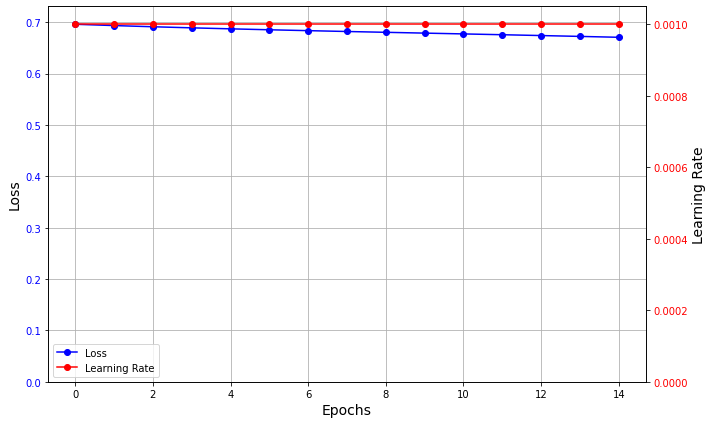

-----------------------------    model_lstmBlock ----------------------------- 
Epoch: 1/30 - learning rate: 0.10000, classification loss: 0.6970
Epoch: 2/30 - learning rate: 0.10000, classification loss: 0.6920
Epoch: 3/30 - learning rate: 0.10000, classification loss: 0.6669
Epoch: 4/30 - learning rate: 0.10000, classification loss: 0.6771
Epoch: 5/30 - learning rate: 0.10000, classification loss: 0.6289
Epoch: 6/30 - learning rate: 0.10000, classification loss: 0.6253
Epoch: 7/30 - learning rate: 0.10000, classification loss: 0.5947
Epoch: 8/30 - learning rate: 0.10000, classification loss: 0.5705
Epoch: 9/30 - learning rate: 0.10000, classification loss: 0.5345
Epoch: 10/30 - learning rate: 0.10000, classification loss: 0.5078
Epoch: 11/30 - learning rate: 0.10000, classification loss: 0.4717
Epoch: 12/30 - learning rate: 0.10000, classification loss: 0.4493
Epoch: 13/30 - learning rate: 0.10000, classification loss: 0.4435
Epoch: 14/30 - learning rate: 0.10000, classification loss

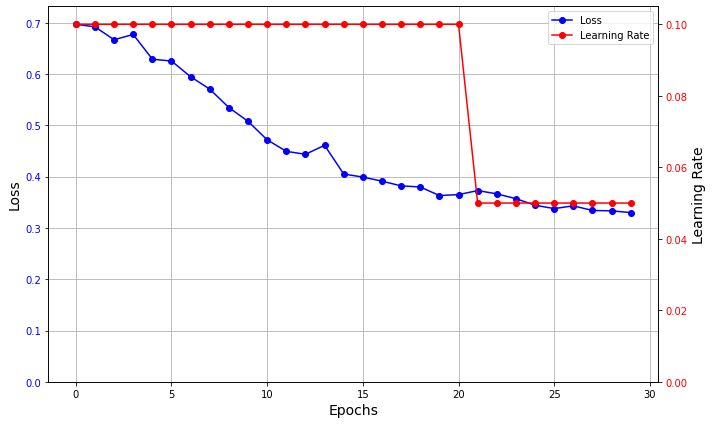

-----------------------------    model_cnnLSTM ----------------------------- 
Epoch: 1/30 - learning rate: 0.00100, classification loss: 0.6939
Epoch: 2/30 - learning rate: 0.00100, classification loss: 0.6767
Epoch: 3/30 - learning rate: 0.00100, classification loss: 0.6648
Epoch: 4/30 - learning rate: 0.00100, classification loss: 0.6503
Epoch: 5/30 - learning rate: 0.00100, classification loss: 0.6350
Epoch: 6/30 - learning rate: 0.00100, classification loss: 0.6161
Epoch: 7/30 - learning rate: 0.00100, classification loss: 0.5990
Epoch: 8/30 - learning rate: 0.00100, classification loss: 0.5791
Epoch: 9/30 - learning rate: 0.00100, classification loss: 0.5582
Epoch: 10/30 - learning rate: 0.00100, classification loss: 0.5388
Epoch: 11/30 - learning rate: 0.00100, classification loss: 0.5177
Epoch: 12/30 - learning rate: 0.00100, classification loss: 0.4982
Epoch: 13/30 - learning rate: 0.00100, classification loss: 0.4798
Epoch: 14/30 - learning rate: 0.00100, classification loss: 

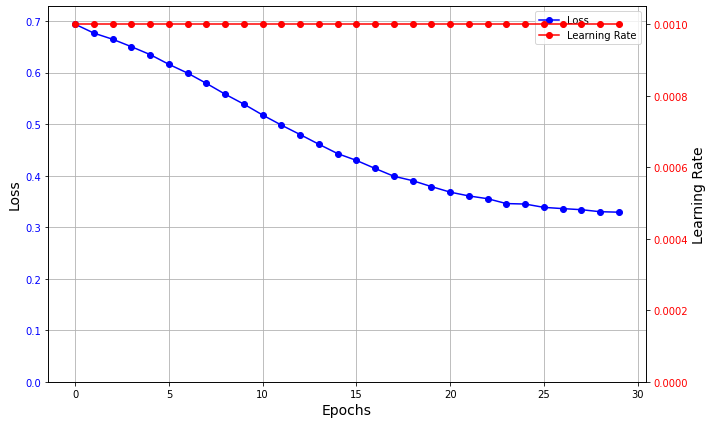

In [111]:
import copy
n_epochs = [15,30,30]
n_epochs_da = 4
lrs = [0.001,0.1, 0.001]

lr_threshold = 0.0005

for ii in range(len(models)):
    lr = lrs[ii]
    print('-----------------------------   ', models_names[ii],'----------------------------- ')
    models[ii], loss_seq, lr_seq = train_loop(models[ii], train_dataloader, lr, n_epochs[ii])
    plot_loss(loss_seq, lr_seq)
    '''
    # Validation
    pre_training_accuracies = validation(test_dataloaders, dataloaders_names, models[ii])
    
    model = copy.deepcopy(models[ii])
    print('                      # Training with target domain data  #')
    
    # Train on target domain and validate again
    post_training_accuracies = []
    for i in range(len(test_dataloaders)):
        dataset = test_dataloaders[i].dataset  # Extract the dataset from your existing DataLoader

        # Split the dataset: 10% for training, 90% for validation
        dataset_size = len(dataset)
        train_size = int(0.1 * dataset_size)
        val_size = dataset_size - train_size

        # Split the dataset
        target_train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        # Create new DataLoaders for training and validation sets
        target_train_dataloader = DataLoader(target_train_dataset, batch_size=test_dataloaders[i].batch_size, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=test_dataloaders[i].batch_size, shuffle=False)

        # Train on target domain data
        model, loss_seq, lr_seq = train_loop(model, target_train_dataloader, lr, n_epochs_da)

        # Validate on the same dataset and collect accuracies post-training
        post_training_accuracy = validation([val_dataloader], [dataloaders_names[i]], model)[0]
        post_training_accuracies.append(post_training_accuracy)
    
        # Reset model to pre-trained state if necessary
        model = copy.deepcopy(models[ii])

    
    # Plot accuracy comparison for the current model
    plot_accuracies(pre_training_accuracies, post_training_accuracies, dataloaders_names, models_names[ii])'''

-----------------------------    sequence ----------------------------- 
                      # Training with target domain data  #
Epoch: 1/4 - learning rate: 0.00100, classification loss: 0.7780
Epoch: 2/4 - learning rate: 0.00100, classification loss: 0.7494
Epoch: 3/4 - learning rate: 0.00100, classification loss: 0.7258
Epoch: 4/4 - learning rate: 0.00100, classification loss: 0.7048


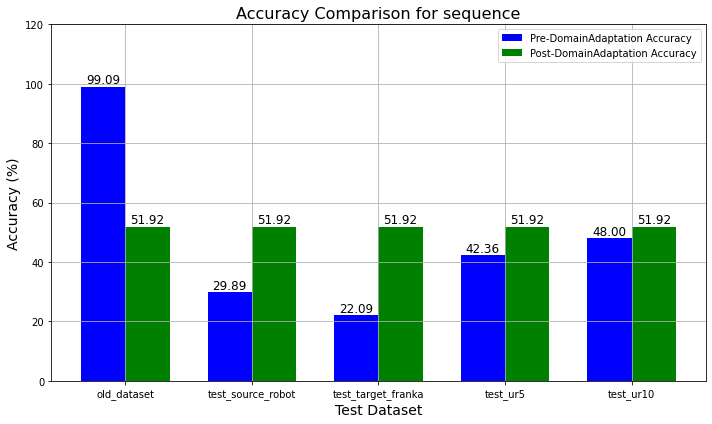

-----------------------------    model_lstmBlock ----------------------------- 
                      # Training with target domain data  #
Epoch: 1/4 - learning rate: 0.10000, classification loss: 0.7553
Epoch: 2/4 - learning rate: 0.10000, classification loss: 0.5052
Epoch: 3/4 - learning rate: 0.10000, classification loss: 0.4710
Epoch: 4/4 - learning rate: 0.10000, classification loss: 0.4882


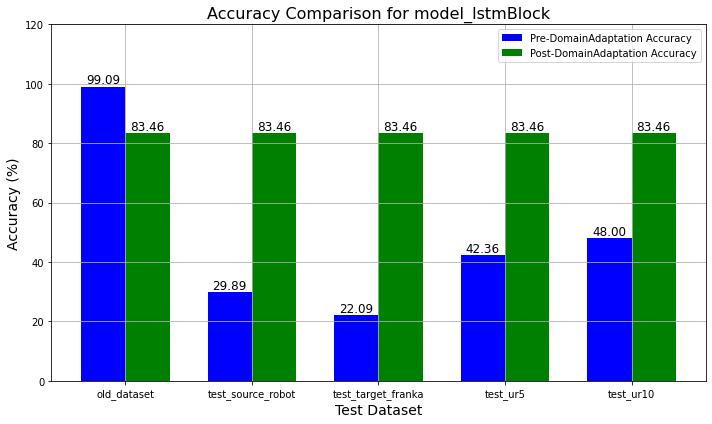

-----------------------------    model_cnnLSTM ----------------------------- 
                      # Training with target domain data  #
Epoch: 1/4 - learning rate: 0.00100, classification loss: 0.7158
Epoch: 2/4 - learning rate: 0.00100, classification loss: 0.4835
Epoch: 3/4 - learning rate: 0.00100, classification loss: 0.4653
Epoch: 4/4 - learning rate: 0.00100, classification loss: 0.4770


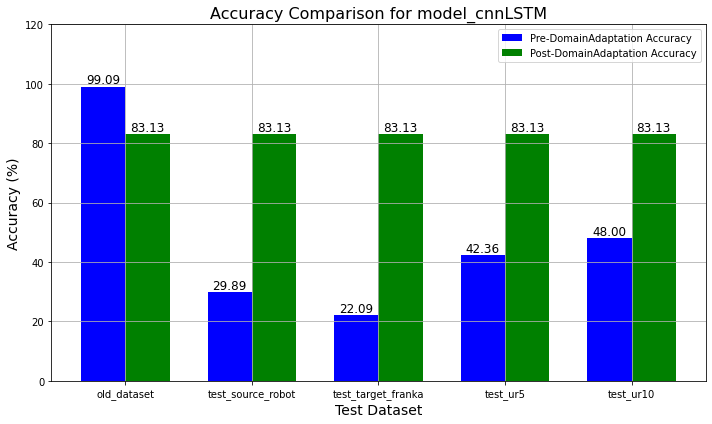

In [112]:
n_epochs_da = [4, 4,4]
lr_threshold = 0.0005

for ii in range(len(models)):
    lr = lrs[ii]
    print('-----------------------------   ', models_names[ii],'----------------------------- ')
    #model = copy.deepcopy(models[ii])
    model = models[ii]
    print('                      # Training with target domain data  #') 
    # Train on target domain and validate again
    post_training_accuracies = []
    for i in [2]:#range(len(test_dataloaders)):
        dataset = test_dataloaders[i].dataset  # Extract the dataset from your existing DataLoader

        # Split the dataset: 10% for training, 90% for validation
        dataset_size = len(dataset)
        train_size = int(0.1 * dataset_size)
        val_size = dataset_size - train_size

        # Split the dataset
        target_train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        # Create new DataLoaders for training and validation sets
        target_train_dataloader = DataLoader(target_train_dataset, batch_size=test_dataloaders[i].batch_size, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=test_dataloaders[i].batch_size, shuffle=False)

        # Train on target domain data
        model, loss_seq, lr_seq = train_loop(model, target_train_dataloader, lr, n_epochs_da[ii])

        # Validate on the same dataset and collect accuracies post-training
        post_training_accuracy = validation([val_dataloader], [dataloaders_names[i]], model)[0]
        post_training_accuracies.append(post_training_accuracy)
        
        torch.save({"model_state_dict": model.state_dict()},main_path+models_names[ii]+dataloaders_names[i]+'.pth')
        
        # Reset model to pre-trained state if necessary
        model = copy.deepcopy(models[ii])
    
    # Plot accuracy comparison for the current model
    plot_accuracies(pre_training_accuracies, post_training_accuracies, dataloaders_names, models_names[ii])

# testing

In [113]:
import matplotlib.pyplot as plt
import plotly.graph_objs as go
def get_features_dof(features, joint_number):
    j = joint_number
    feature_j = []
    for i in range(len(features)) :
        feature_j.append(f'{features[i]}{j}' )
    return feature_j

# trained with training set
#contact_detection_path= main_path + 'model_cnnLSTMtest_source_robot.pth'

#model_contact = copy.deepcopy(models[0])
#checkpoint = torch.load(contact_detection_path)
#model_contact.load_state_dict(checkpoint["model_state_dict"])
#model_contact.to(device)

features = ['tau_J', 'tau_ext', 'e', 'de']
dof = 7
#features_num = len(features)*dof
num_features_lstm = len(features)
window_length = 28
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
testing_data = pd.read_csv('/home/rzma/myProjects/contactInterpretation/frankaRobot/DATA/dataset/2024_07_24_link5/labeled_data.csv')
testing_data['model_out'] = testing_data.label
testing_data = testing_data[testing_data.index < 3000]; testing_data.reset_index(inplace=True)


for model in models:
    model_contact = copy.deepcopy(model)
    model_contact.eval()

    for t_i in range(window_length, testing_data.shape[0]):
        #building data window
        window = []
        for joint_number in range(dof):
            feature_j = get_features_dof(features=features, joint_number=joint_number)
            joint_row = np.hstack(testing_data[feature_j][t_i-window_length:t_i].values)
            window.append(joint_row)
            
        window = np.array([window])
        window = torch.tensor(window).to(device).double()
        with torch.no_grad():
            #window = transform(window).to(device).float()
            model_out = model_contact(window)
            probabilities = F.softmax(model_out)
            #model_out = (probabilities > 0.6).int() 

            testing_data.loc[t_i-1, 'model_out'] =probabilities.argmax().item()#probabilities[probabilities.argmax().item()].item()*probabilities.argmax().item()


    # Create traces for the first dataset
    traces = []
    traces.append(go.Scatter(x=testing_data['time'], y=testing_data['label'], mode='lines', name='label'))
    traces.append(go.Scatter(x=testing_data['time'], y=testing_data['model_out'], mode='lines', name='model_out'))

    # Create the layout
    layout = go.Layout(
        title='Combined Plot',
        xaxis=dict(title='Time'),
        yaxis=dict(title='Values'),
        showlegend=True
    )

    # Create the figure and plot it
    fig = go.Figure(data=traces, layout=layout)
    fig.show()
    # calculate latency per contact event
    n = 80
    detection_delays = []
    true_label_index = testing_data.label[testing_data.label.diff()>0.9].index
    no_contact_start_index = testing_data.label[testing_data.label.diff()<-0.8].index
    no_contact_start_index = no_contact_start_index[no_contact_start_index>true_label_index[0]]

    predicted_label_index = testing_data.model_out[testing_data.model_out.diff()>0.9].index
    true_positive= np.zeros_like(true_label_index)
    counter = 0
    for i, end_i in zip(true_label_index, no_contact_start_index):
        state = False
        for j in range(end_i-i): 
            #if testing_data.model_out[i+j]:
            if (i+j) in predicted_label_index:
                detection_delays.append(testing_data.time[i+j]-testing_data.time[i])
                true_positive[counter]=1
                counter = counter +1
                state=True
                break
        if not state:
            true_positive[counter]=0
            counter = counter +1


    print('Single contact analysis')
    print(f'Correctly detected contacts(TP): {np.sum(true_positive)},   contact labels: {len(true_label_index)}, percision: {np.sum(true_positive)/len(true_label_index)} ')
    print(f'Effective Detection delay: {np.sum(detection_delays)/len(detection_delays):.3f} seconds')
    %matplotlib inline
    #plt.hist(detection_delays, bins=20)
    #plt.show()
    #plt.boxplot(detection_delays)



/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/torch/nn/modules/rnn.py:692: UserWarning:

RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:925.)

/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Single contact analysis
Correctly detected contacts(TP): 5,   contact labels: 5, percision: 1.0 
Effective Detection delay: 0.061 seconds


/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/torch/nn/modules/rnn.py:692: UserWarning:

RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:925.)

/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Single contact analysis
Correctly detected contacts(TP): 0,   contact labels: 5, percision: 0.0 
Effective Detection delay: nan seconds


/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:95: RuntimeWarning:

invalid value encountered in double_scalars

/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/torch/nn/modules/rnn.py:692: UserWarning:

RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:925.)

/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Single contact analysis
Correctly detected contacts(TP): 0,   contact labels: 5, percision: 0.0 
Effective Detection delay: nan seconds


/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:95: RuntimeWarning:

invalid value encountered in double_scalars



## ur5

In [114]:
save_data_file = main_path + 'urRobot/DATA/dataset/21/'
def get_features_dof(features, joint_number):
    j = joint_number
    feature_j = []
    for i in range(len(features)) :
        feature_j.append(f'{features[i]}{j}' )
    return feature_j


features = ['target_moment_', 'e_i', 'e', 'de']
dof = 6
#features_num = len(features)*dof
num_features_lstm = len(features)

window_length = 28

k_tau = np.array([0.1082, 0.1100, 0.1097, 0.0787, 0.0294, 0.0261])*10 #ur robot support file
#k_tau = [1.35,  1.361, 1.355, 0.957, 0.865, 0.893] #my finding
#k_tau = np.array([0.1155, 0.1149 , 0.0988, 0.1032, 0.1033, 0.1030])*10 #ur10e
e_i = [f'e_i{i}' for i in range(dof)]

testing_data = pd.read_csv(save_data_file+'labeled_data.csv')
for i in range(len(e_i)):
    testing_data[e_i[i]]=testing_data[e_i[i]]*k_tau[i]

testing_data['model_out'] = testing_data.label
#testing_data = testing_data[testing_data.index > 4000]; testing_data.reset_index(inplace=True)
# trained with training set
'''contact_detection_path= main_path + 'sequencetest_ur5.pth'

model_contact = copy.deepcopy(models[2])
checkpoint = torch.load(contact_detection_path)
model_contact.load_state_dict(checkpoint["model_state_dict"])
model_contact.to(device)
'''

for model in models:
    model_contact = copy.deepcopy(model)
    model_contact.eval()

    for t_i in range(window_length, testing_data.shape[0]):
        #building data window
        window = []
        for joint_number in range(dof):
            feature_j = get_features_dof(features=features, joint_number=joint_number)
            joint_row = np.hstack(testing_data[feature_j][t_i-window_length:t_i].values)
            window.append(joint_row)
            
        #window = np.array(window)
        window = np.array([window])
        window_transformed = torch.tensor(window).to(device)
        with torch.no_grad():
            #window_transformed = transform(window).to(device).float()
            model_out = model_contact(window_transformed)
            #model_out = (model_out > 0.8).int() 
            probabilities = F.softmax(model_out) 
            testing_data.loc[t_i-1, 'model_out'] = probabilities[probabilities.argmax().item()].item()*probabilities.argmax().item()


    # Create traces for the first dataset
    traces = []
    traces.append(go.Scatter(x=testing_data['time'], y=testing_data['label'], mode='lines', name='label'))
    traces.append(go.Scatter(x=testing_data['time'], y=testing_data['model_out'], mode='lines', name='model_out'))

    # Create the layout
    layout = go.Layout(
        title='Combined Plot',
        xaxis=dict(title='Time'),
        yaxis=dict(title='Values'),
        showlegend=True
    )

    # Create the figure and plot it
    fig = go.Figure(data=traces, layout=layout)
    fig.show()
    # calculate latency per contact event
    n = 80
    detection_delays = []
    true_label_index = testing_data.label[testing_data.label.diff()>0.9].index
    no_contact_start_index = testing_data.label[testing_data.label.diff()<-0.8].index
    no_contact_start_index = no_contact_start_index[no_contact_start_index>true_label_index[0]]

    predicted_label_index = testing_data.model_out[testing_data.model_out.diff()>0.9].index
    true_positive= np.zeros_like(true_label_index)
    counter = 0
    for i, end_i in zip(true_label_index, no_contact_start_index):
        state = False
        for j in range(end_i-i): 
            #if testing_data.model_out[i+j]:
            if (i+j) in predicted_label_index:
                detection_delays.append(testing_data.time[i+j]-testing_data.time[i])
                true_positive[counter]=1
                counter = counter +1
                state=True
                break
        if not state:
            true_positive[counter]=0
            counter = counter +1


    print('Single contact analysis')
    print(f'Correctly detected contacts(TP): {np.sum(true_positive)},   contact labels: {len(true_label_index)}, percision: {np.sum(true_positive)/len(true_label_index)} ')
    print(f'Effective Detection delay: {np.sum(detection_delays)/len(detection_delays):.3f} seconds')
    %matplotlib inline
    #plt.hist(detection_delays, bins=20)
    #plt.show()
    #plt.boxplot(detection_delays)
    

/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/torch/nn/modules/rnn.py:692: UserWarning:

RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:925.)

/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Single contact analysis
Correctly detected contacts(TP): 0,   contact labels: 6, percision: 0.0 
Effective Detection delay: nan seconds


/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:103: RuntimeWarning:

invalid value encountered in double_scalars

/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/torch/nn/modules/rnn.py:692: UserWarning:

RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:925.)

/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Single contact analysis
Correctly detected contacts(TP): 0,   contact labels: 6, percision: 0.0 
Effective Detection delay: nan seconds


/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:103: RuntimeWarning:

invalid value encountered in double_scalars

/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/torch/nn/modules/rnn.py:692: UserWarning:

RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:925.)

/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Single contact analysis
Correctly detected contacts(TP): 0,   contact labels: 6, percision: 0.0 
Effective Detection delay: nan seconds


/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:103: RuntimeWarning:

invalid value encountered in double_scalars

